## Fetch Dataset

In [1]:
! git clone https://github.com/premnagdeo/Intrusion-Detection-System.git
% cd Intrusion-Detection-System

Cloning into 'Intrusion-Detection-System'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 5), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.
/content/Intrusion-Detection-System


## Import Libraries

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import urllib.parse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import random

## Load the datasets

In [3]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))   #converting url encoded data to simple string
        result.append(d)
    return result

In [4]:
maliciousQueries = loadFile('maliciousqueries.txt')
validQueries = loadFile('validqueries.txt')

### Print Random Valid and Malicious Queries

In [5]:
print(random.choices(validQueries, k=5))

['/unreal tournament ost/\n', '/q59884851\n', '/blubutn/\n', '/v14962103/\n', '/javascript/hyper.zip\n']


In [6]:
print(random.choices(maliciousQueries, k=5))

["alert('foo');\n", '/recordings/ftp/ftp.pl?dir=../../../../../../etc\n', '<meta http-equiv=set-cookie content="testtfvh=2141">\n', '/scripts/upload.cgi\n', '//document.writeln(unescape("<script src=\'http://www.example.com/test?rnd=q56134844\'><"+string.fromcharcode(0x2f)+"script>"))\n']


## Data Preprocessing

In [7]:
maliciousQueries = list(set(maliciousQueries))
validQueries = list(set(validQueries))
allQueries = maliciousQueries + validQueries

### set ylabels as 1 for malicious and 0 for valid

In [8]:
yMalicious = [1 for i in range(0, len(maliciousQueries))]
yValid = [0 for i in range(0, len(validQueries))]

In [9]:
y = yMalicious + yValid
queries = allQueries
print(queries[:10])

["<IMG SRC='vbscript:msgbox(document.location)'>\n", '"|echo XLPJUH$((63+35))$(echo XLPJUH)XLPJUH//\n', '/scripts/index.php?setlang=gcards_dir_transversal.nasl&lang[gcards_dir_transversal.nasl][file]=../../../../../../../../../../../../etc/passwd\n', ' or 0=0 --\n', '"&&echo$IFSWJRXOQ$((50+45))$(echo$IFSWJRXOQ)WJRXOQ//\n', '/m2fpztty.kspx?<script>cross_site_scripting.nasl</script>\n', '/examples/jsp/num/bb_func_txt.php?pathtofiles=/etc/passwd\\x00\n', '/9kr0ih0v.do?<meta http-equiv=set-cookie content="testzgnm=1183">\n', '/giftsubscriptionzip/\n', '/o6ebbirj.dll?<img src="javascript:alert(cross_site_scripting.nasl);">\n']


### Vectorization

In [10]:
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3))
X = vectorizer.fit_transform(queries)

### Split Data into Train and Test Set

###### Train:Test Split: 80:20

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
print("Number of samples in Training Set =", X_train.shape[0])
print("Number of samples in Test Set =", X_test.shape[0])

Number of samples in Training Set = 1048404
Number of samples in Test Set = 262102


In [13]:
maliciousCount = len(maliciousQueries)
validCount = len(validQueries)

In [14]:
print("Total Number of valid queries =", validCount)
print("Total Number of malicious queries =", maliciousCount)

Total Number of valid queries = 1265974
Total Number of malicious queries = 44532


In [15]:
print(sum(y_test))

8847


### Logistic Regression

In [16]:
regressor = LogisticRegression(class_weight={1: 2 * validCount / maliciousCount, 0: 1.0}, max_iter=1000)

### Train the model

In [17]:
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 56.856822060540736},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=1000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

## Evaluation

In [18]:
y_pred = regressor.predict(X_test)

In [19]:
fpr, tpr, _ = metrics.roc_curve(y_test, (regressor.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

In [20]:
print("Malicious samples: %d" % maliciousCount)
print("Valid samples: %d" % validCount)
print("Baseline Constant negative: %.6f" % (validCount / (validCount + maliciousCount)))
print("------------")
print("Accuracy: %f" % regressor.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, y_pred))
print("Recall: %f" % metrics.recall_score(y_test, y_pred))
print("F1-Score: %f" % metrics.f1_score(y_test, y_pred))
print("AUC: %f" % auc)


Malicious samples: 44532
Valid samples: 1265974
Baseline Constant negative: 0.966019
------------
Accuracy: 0.999424
Precision: 0.984619
Recall: 0.998531
F1-Score: 0.991526
AUC: 0.999868


In [21]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253255
           1       0.98      1.00      0.99      8847

    accuracy                           1.00    262102
   macro avg       0.99      1.00      1.00    262102
weighted avg       1.00      1.00      1.00    262102



## Confusion Matrix

In [22]:
print(metrics.confusion_matrix(y_test, y_pred))

[[253117    138]
 [    13   8834]]


### Plot the Confusion Matrix

Model Accuracy: 0.999424


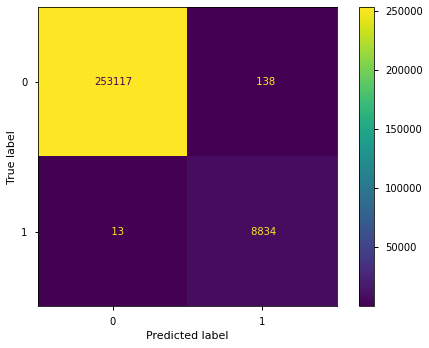

In [23]:
plt.style.use('seaborn-notebook')
confusion_matrix = metrics.plot_confusion_matrix(regressor, X_test, y_test, values_format='5d')
print("Model Accuracy: %f" % regressor.score(X_test, y_test))  
plt.show()

## Save the model

In [24]:
import pickle

pickle.dump(regressor, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))

### Load the model

In [25]:
loaded_model = pickle.load(open('model.pkl', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)


0.9994238884098557


### Test the model against user data

In [26]:
model = pickle.load(open('model.pkl','rb'))
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

#### Malicious query test

In [27]:
query_list = ["<SCRIPT/XSS SRC=\"http://ha.ckers.org/xss.js\"></SCRIPT>", "/javascript/mta.exe"]
querys = vectorizer.transform(query_list)
results = model.predict(querys)
print(results)

[1 1]


#### Valid query test

In [28]:
query_list = ["/main/learn-python/", "/index.html"]
querys = vectorizer.transform(query_list)
results = model.predict(querys)
print(results)

[0 0]
